# API example: end-to-end adversarial detection

This notebook shows how to use the **high-level public API** (re-exported from `src`) to:

- load a dataset from the registry
- build/train a model
- generate adversarial examples (FGSM/PGD)
- compute graph/topology scores
- fit the detector
- evaluate AUROC/AUPRC/FPR@95%TPR

Notes:
- This repo’s detector is standardized to the **topology-score detector** (`TopologyScoreDetector`).
- External datasets (MNIST/CIFAR via torchvision) are supported **without auto-download by default**.


In [ ]:
import numpy as np
import sys
from pathlib import Path

# Make `import src.*` work when running from nested directory
REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / "src").exists() and (REPO_ROOT.parent / "src").exists():
    REPO_ROOT = REPO_ROOT.parent.resolve()

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
    
from src import (
    ExperimentConfig,
    load_config,
    list_datasets,
    list_models,
    run_pipeline,
)

# Load a base YAML config from ./config/ (convenience wrapper)
cfg = load_config("fgsm_eps0p02_pca20")

print("datasets:", list_datasets())
print("models:", list_models())

datasets: ['breast_cancer_tabular', 'cifar10', 'cifar100', 'fashion_mnist', 'mnist', 'synthetic_shapes_2class', 'synthetic_shapes_3class', 'two_moons']
models: ['minicnn', 'two_moons_mlp']


Epoch [10/100] Train Loss: 0.1165, Train Acc: 95.83%, Val Loss: 0.1320, Val Acc: 94.00%
Epoch [20/100] Train Loss: 0.0267, Train Acc: 99.17%, Val Loss: 0.0324, Val Acc: 99.00%
Epoch [30/100] Train Loss: 0.0124, Train Acc: 99.67%, Val Loss: 0.0144, Val Acc: 100.00%
Epoch [40/100] Train Loss: 0.0077, Train Acc: 99.83%, Val Loss: 0.0083, Val Acc: 100.00%
Epoch [50/100] Train Loss: 0.0053, Train Acc: 100.00%, Val Loss: 0.0059, Val Acc: 100.00%
Epoch [60/100] Train Loss: 0.0041, Train Acc: 100.00%, Val Loss: 0.0044, Val Acc: 100.00%
Epoch [70/100] Train Loss: 0.0030, Train Acc: 100.00%, Val Loss: 0.0033, Val Acc: 100.00%
Epoch [80/100] Train Loss: 0.0024, Train Acc: 100.00%, Val Loss: 0.0024, Val Acc: 100.00%
Epoch [90/100] Train Loss: 0.0020, Train Acc: 100.00%, Val Loss: 0.0021, Val Acc: 100.00%
Epoch [100/100] Train Loss: 0.0016, Train Acc: 100.00%, Val Loss: 0.0018, Val Acc: 100.00%
AUROC: 0.5099499999999999
AUPRC: 0.5328900197137644
FPR@95TPR: 0.92


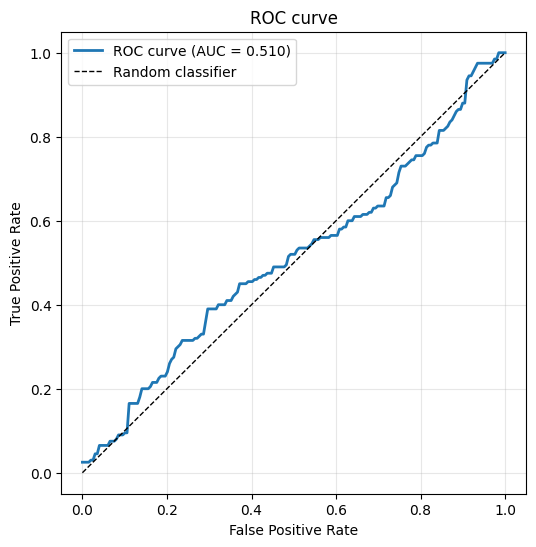

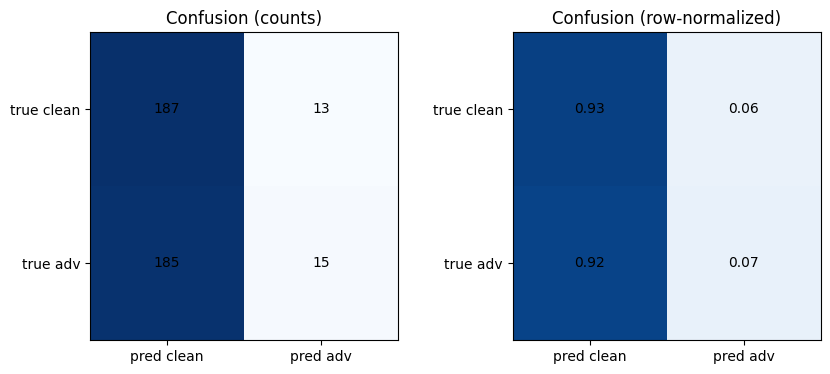

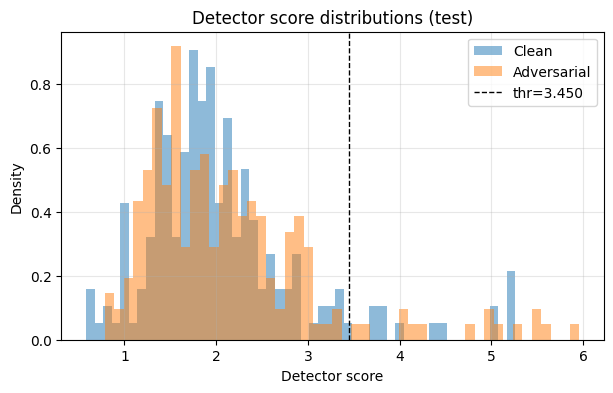

In [10]:
# End-to-end run on a built-in dataset (two moons)
result = run_pipeline(
    dataset_name="two_moons",
    model_name="two_moons_mlp",
    cfg=cfg,
    max_points_for_scoring=400,  # optional: keeps scoring runtime manageable
    seed=cfg.seed,
)

print("AUROC:", result.eval.metrics["roc_auc"])
print("AUPRC:", result.eval.metrics["pr_auc"])
print("FPR@95TPR:", result.eval.metrics["fpr_at_tpr95"])

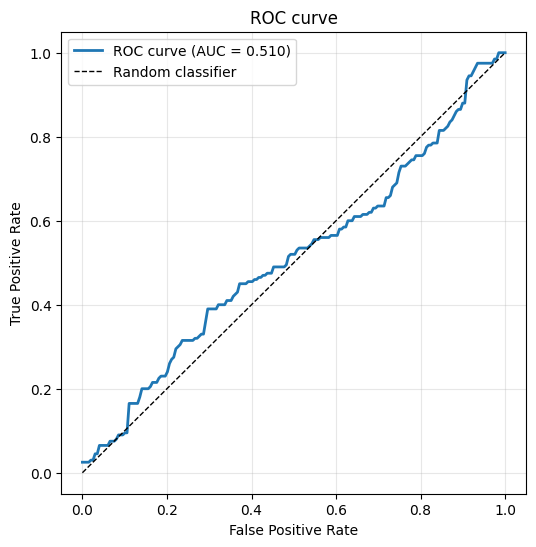

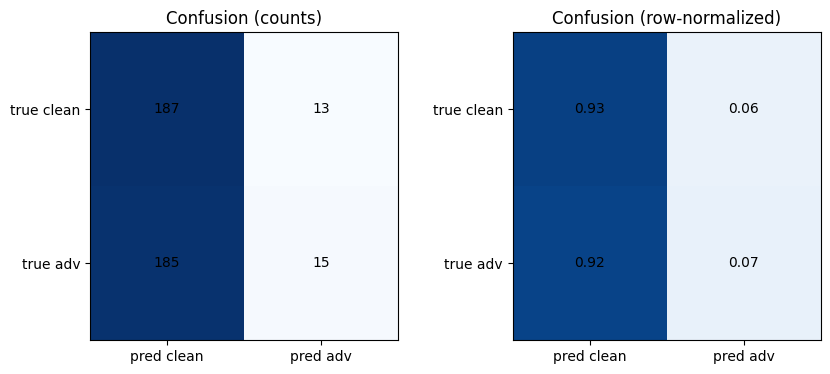

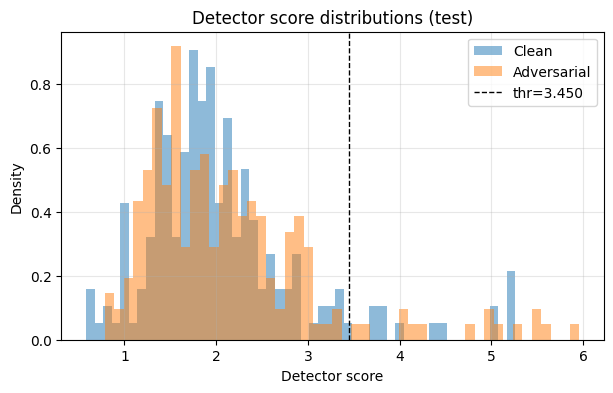

In [11]:
# Plots are now included in the pipeline output
roc_fig = result.eval.plots.get("roc_fig")
conf_fig = result.eval.plots.get("confusion_fig")
score_fig = result.eval.plots.get("score_dist_fig")

for fig in [roc_fig, conf_fig, score_fig]:
    if fig is not None:
        display(fig)

if "plot_error" in result.eval.plots:
    print("Plotting error:", result.eval.plots["plot_error"])

## External datasets (torchvision)

The dataset registry includes torchvision-backed datasets:
- `mnist`, `fashion_mnist`, `cifar10`, `cifar100`

By default this repo does **not** auto-download them. Provide a local `cfg.data.root` (or set `cfg.data.download=True`).

If the dataset isn’t present locally, torchvision will raise an error — the next cell demonstrates the intended usage pattern.

In [12]:
from src import get_dataset, get_model

cfg_ext = ExperimentConfig()
cfg_ext.seed = 123
cfg_ext.device = "cpu"

# IMPORTANT: dataset has to be in the data directory
cfg_ext.data.root = "./data"
cfg_ext.data.download = False

try:
    cifar = get_dataset("cifar10", cfg_ext)
    print("Loaded CIFAR-10:", cifar.X_train.shape, cifar.y_train.shape)

    # MiniCNN supports channel count via in_channels
    model = get_model(
        "minicnn",
        cfg_ext,
        num_classes=int(cifar.meta["num_classes"]),
        in_channels=int(cifar.meta.get("channels") or 3),
    )
    print("Model:", type(model).__name__)
except Exception as e:
    print("Could not load CIFAR-10 from cfg_ext.data.root (expected if not present):")
    print(repr(e))

Could not load CIFAR-10 from cfg_ext.data.root (expected if not present):
ImportError('Torchvision datasets require torchvision.\nInstall with: pip install torchvision\n')
